In [1]:
from PIL import Image, ImageDraw
from math import floor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay
from random import seed
from random import randint
from random import getrandbits

In [2]:
def run_kernel_HW():
    # Transfer color channel 0
    in_buffer[:] = np.array(original_image)[:,:,[0]]
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer0)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    # Transfer color channel 1
    in_buffer[:] = np.array(original_image)[:,:,[1]]
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer1)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    # Transfer color channel 2
    in_buffer[:] = np.array(original_image)[:,:,[2]]
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer2)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [3]:
def run_kernel_SW():
    # Load image:
    input_image = original_image
    input_pixels = input_image.load()

    # Middle of the kernel
    offset = len(kernel) // 2
    new_width = input_image.size[0]-offset
    new_height = input_image.size[0]-offset
    # Create output image
    output_image = Image.new("RGB", (new_width,new_height))
    draw = ImageDraw.Draw(output_image)

    # Compute convolution with kernel
    for x in range(offset, input_image.width - offset):
        for y in range(offset, input_image.height - offset):
            acc = [0, 0, 0]
            for a in range(len(kernel)):
                for b in range(len(kernel)):
                    xn = x + a - offset
                    yn = y + b - offset
                    pixel = input_pixels[xn, yn]
                    acc[0] += pixel[0] * kernel[a][b]
                    acc[1] += pixel[1] * kernel[a][b]
                    acc[2] += pixel[2] * kernel[a][b]

            draw.point((x, y), (int(acc[0]), int(acc[1]), int(acc[2])))

    output_image.save("Output/output_sw.png")

In [4]:
filterBase = 24
dataBase = 60
def output_registers():
    print("Control Enable:         %d" % (controller.read(0)))
    print("Reset:                  %d" % (controller.read(4)))
    print("State Machine Register: %d" % (controller.read(8)))
    print("Last Calculated Value:  %d" % (controller.read(12)))
    print("Image Width:            %d" % (controller.read(16)))
    print("Image Height:           %d" % (controller.read(20)))
    print("\nFilter Set:")
    for i in range(9):
        print("filterSet[%d] = %d" % (i,controller.read((i*4)+filterBase)))
    print("\nData Set:")
    for i in range(9):
        print("dataSet[%d] = %d" % (i,controller.read((i*4)+dataBase)))
    print("\n")

## Configurable Hardware Image Convolution

Select an image from the /Images dir

**To run on hardware convolution, image witdh must be a multiple of 32/DATA_WIDTH. E.g. 8 bit input must be a multiple of 4 in width.**

 - This is due to the way BRAM coupler is storing/reading from BRAM memory map.

In [5]:
image_path = "Images/w1080/-KondVvbokg.jpg"
original_image = Image.open(image_path)

Original Image size: 1080x720 pixels.


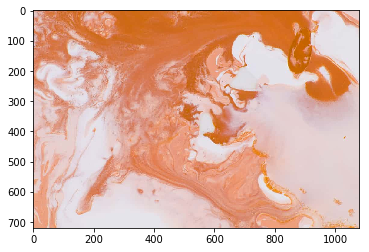

In [6]:
width, height = original_image.size
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size)
print("Original Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(original_image)

#### Bit precision selection:
 - 0 for 8 bit data
 - 1 for 16 bit data
 - 2 for 32 bit data
 
(Should not runtime for hardware)

In [7]:
bit_precision = 0

if(bit_precision==0):
    Convolution_design = Overlay("Hardware-Files/Stable/PL_Convolution_8b.bit",)
elif(bit_precision==1):
    Convolution_design = Overlay("Hardware-Files/Stable/PL_Convolution_16b.bit",)
elif(bit_precision==2):
    Convolution_design = Overlay("Hardware-Files/Stable/PL_Convolution_32b.bit",)

dma = Convolution_design.axi_dma_0
controller = Convolution_design.Convolution_Controll_0

In [8]:
# Creating Correct precision input buffer
if(bit_precision==0):
    in_buffer = allocate(shape=(height, width, 1),dtype=np.uint8, cacheable=1)
elif(bit_precision==1):
    in_buffer = allocate(shape=(height, width, 1),dtype=np.uint16, cacheable=1)
elif(bit_precision==2):
    in_buffer = allocate(shape=(height, width, 1),dtype=np.uint32, cacheable=1)

# Single channel buffers
out_buffer0 = allocate(shape=(height-2, width-2, 1),dtype=np.uint32, cacheable=1)
out_buffer1 = allocate(shape=(height-2, width-2, 1),dtype=np.uint32, cacheable=1)
out_buffer2 = allocate(shape=(height-2, width-2, 1),dtype=np.uint32, cacheable=1)
# Three channel buffer for combining channels
out_buffer = allocate(shape=(height-2, width-2, 3),dtype=np.uint8, cacheable=1)

In [9]:
kernelsize = 3
# High-pass kernel
kernel = [[ 1, 1, 1 ],
          [ 1, 1, 1 ],
          [ 1, 1, 1 ]]

In [10]:
#Enable IP control register
controller.write(0,1)

#Input Filter set
for x in range(kernelsize):
    for y in range(kernelsize):
        controller.write(filterBase+((x*kernelsize)+y)*4,kernel[y][x])

#Input width/height
controller.write(16,width)#Width
controller.write(20,height)#Height

In [11]:
# %%timeit

# Hardware performance
run_kernel_HW()

KeyboardInterrupt: 

In [12]:
# %%timeit

# Software performance
run_kernel_SW()

KeyboardInterrupt: 

In [13]:
# Clipping values to be in correct bit range for RGB png
min = 0
max = 255
out_buffer[:,:,[0]] = np.clip(out_buffer0, 0, max)
out_buffer[:,:,[1]]  = np.clip(out_buffer1, 0, max)
out_buffer[:,:,[2]]= np.clip(out_buffer2, 0, max)

Convolution Image size: 1078x718 pixels.
Note: this bit precision is likely to saturate very quickly. As of now this overflows count


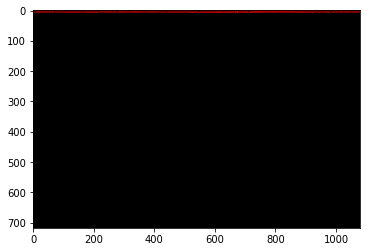

In [14]:
convolution_image = Image.fromarray(out_buffer)
conv_width, conv_height = convolution_image.size

canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size)
print("Convolution Image size: {}x{} pixels.".format(conv_width, conv_height))
_ = plt.imshow(convolution_image)
convolution_image.save("Output/output_hw.png", "PNG")

if(bit_precision==0):
    print("Note: this bit precision is likely to saturate very quickly. As of now this overflows count")

### Ouput files are located in "jupyter_notebooks/PL_Convolution/Output"
**Software output will not appear in dir if %%timeit was used**